In [4]:
import torch
from torch.autograd import grad
from torch.nn import functional
import matplotlib.pyplot as plt
import pandas as pd
import math

In [ ]:
#datset
data=pd.read_csv("dataset/Iris.csv")
data = data[data["Species"].isin(['Iris-setosa', 'Iris-versicolor'])]
data['Species'] = data['Species'].map({'Iris-setosa': 0, 'Iris-versicolor': 1})
X = data[['SepalLengthCm', 'SepalWidthCm']].values.tolist()
y = list(data['Species'])
print("len of X: ",len(X))
print("len of y: ",len(y))
print(X[:5])
print(y[:5])
X=torch.tensor(X,dtype=torch.float32)
y=torch.tensor(y,dtype=torch.float32)
torch.manual_seed(42)
shuffle_indices= torch.randperm(len(y),dtype=torch.long)
X=X[shuffle_indices]
y=y[shuffle_indices]
x_train,x_test=X[:70],X[70:]
y_train,y_test=y[:70],y[70:]
# Standarization
mu = x_train.mean(dim=0)
sigma = x_train.std(dim=0)
X_train = (x_train - mu) / sigma
X_test = (x_test - mu) / sigma

len of X:  100
len of y:  100
[[5.1, 3.5], [4.9, 3.0], [4.7, 3.2], [4.6, 3.1], [5.0, 3.6]]
[0, 0, 0, 0, 0]


In [ ]:
class adaline(): #adaline using grad for backpropagation
    def __init__(self, num_features=2,lr=0.001):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, dtype=torch.float32,requires_grad=True)
        self.bias = torch.zeros(1, dtype=torch.float32,requires_grad=True)
        self.lr=lr
    def activation(self,x):
        sigmoid=torch.tensor([1/(1+math.exp(-i)) for i in x])
        return sigmoid
    def forward(self, x):
        x_w = torch.add(torch.mm(x, self.weights), self.bias)

        # x_w=self.activation(x_w)
        return x_w.view(-1)
    def backward(self, loss):
        loss_w=grad(loss,self.weights,retain_graph=True)
        weight_error=loss_w[0]*self.lr
        loss_b=grad(loss,self.bias)
        bias_error=loss_b[0]*self.lr
        self.weights=self.weights- weight_error
        self.bias=self.bias-bias_error

    def mean_square_error(self,y_pred,y): 
        error=torch.mean((y_pred-y)**2)
        return error

In [70]:
def train_adaline(X,y, model, epochs=10,batch_size=8):
    torch.manual_seed(42)
    error_per_epoch=[]

    for e in range(epochs):
        shuffle_indices= torch.randperm(len(y),dtype=torch.long)
        minibatch=torch.split(shuffle_indices,batch_size)
        for n,batch_index in enumerate(minibatch):
            y_pred=model.forward(X[batch_index])
            batch_loss=model.mean_square_error(y_pred,y[batch_index])

            model.backward(batch_loss)
            # model.weights-=lr*w_grad
            # model.bias-=lr*b_grad
            print(f"Batch {n}   loss: {batch_loss}")
        with torch.no_grad(): 
            y_pred = model.forward(X)
            epoch_loss=model.mean_square_error(y_pred,y)
            error_per_epoch.append(epoch_loss)
            print(f"Epoch : {e}  ;  loss: {epoch_loss:.2f}")
    return error_per_epoch

In [74]:
model=adaline()
loss=train_adaline(X_train,y_train.float(),model,epochs= 100)


print("Weights: ",model.weights)
print("bias: ",model.bias)

Batch 0   loss: 0.375
Batch 1   loss: 0.249331533908844
Batch 2   loss: 0.4976593852043152
Batch 3   loss: 0.7427288293838501
Batch 4   loss: 0.6163316965103149
Batch 5   loss: 0.6121906042098999
Batch 6   loss: 0.24422329664230347
Batch 7   loss: 0.7327268123626709
Batch 8   loss: 0.6465808153152466
Epoch : 0  ;  loss: 0.51
Batch 0   loss: 0.2375829517841339
Batch 1   loss: 0.4818008840084076
Batch 2   loss: 0.4776850938796997
Batch 3   loss: 0.5937143564224243
Batch 4   loss: 0.47445785999298096
Batch 5   loss: 0.5932565927505493
Batch 6   loss: 0.8284997344017029
Batch 7   loss: 0.35252469778060913
Batch 8   loss: 0.46687576174736023
Epoch : 1  ;  loss: 0.49
Batch 0   loss: 0.4627667963504791
Batch 1   loss: 0.45988309383392334
Batch 2   loss: 0.3483605980873108
Batch 3   loss: 0.46135419607162476
Batch 4   loss: 0.573004424571991
Batch 5   loss: 0.11450120806694031
Batch 6   loss: 0.9126564860343933
Batch 7   loss: 0.5664042830467224
Batch 8   loss: 0.4472537934780121
Epoch : 2  ; 

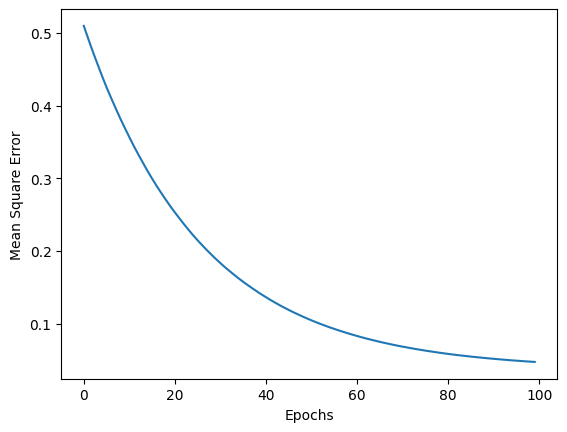

In [75]:
plt.plot(range(len(loss)), loss)
plt.ylabel('Mean Square Error')
plt.xlabel('Epochs')
plt.show()

In [81]:
with torch.no_grad():
    train_res=model.forward(X_train)
    test_results=model.forward(X_test)
train_class=[1 if i>=0.5 else 0 for i in train_res]
correct_train= sum(p == t for p, t in zip(train_class, y_train))
test_class=[1 if i>=0.5 else 0 for i in test_results]
correct= sum(p == t for p, t in zip(test_class, y_test))
print("Train Accuracy: ", correct_train.tolist()/len(y_train) )
print("Correct : ",correct.tolist())
print("Wrong: ",len(y_test)-correct.tolist())
corr=correct.tolist()/len(y_test)
print(f"Accuracy: {corr:.2f}  ")

Train Accuracy:  1.0
Correct :  29
Wrong:  1
Accuracy: 0.97  


In [92]:
class AdalineAuto(torch.nn.Module):
    def __init__(self, features=2):
        super(AdalineAuto, self).__init__()
        self.linear=torch.nn.Linear(features,1) #initailize the weoghts with random numbers
        self.linear.weight.detach().zero_() #in place operation
        self.linear.bias.detach().zero_() 
    def forward(self,X):
        z=self.linear(X)
        return z.view(-1)

def train_adaline(X,y, model, epochs=10,batch_size=8,lr=0.001):
    torch.manual_seed(42)
    error_per_epoch=[]
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for e in range(epochs):
        shuffle_indices= torch.randperm(len(y),dtype=torch.long)
        minibatch=torch.split(shuffle_indices,batch_size)
        for n,batch_index in enumerate(minibatch):
            y_pred=model.forward(X[batch_index])
            batch_loss=functional.mse_loss(y_pred, y[batch_index])
            optimizer.zero_grad()
            batch_loss.backward()

            optimizer.step()

            print(f"Batch {n}   loss: {batch_loss}")
        with torch.no_grad(): 
            y_pred = model.forward(X)
            epoch_loss=functional.mse_loss(y_pred, y)
            error_per_epoch.append(epoch_loss)
            print(f"Epoch : {e}  ;  loss: {epoch_loss:.2f}")
    return error_per_epoch



In [94]:
model=AdalineAuto()
loss=train_adaline(X_train,y_train.float(),model,epochs= 100)

Batch 0   loss: 0.375
Batch 1   loss: 0.249331533908844
Batch 2   loss: 0.4976593852043152
Batch 3   loss: 0.7427288293838501
Batch 4   loss: 0.6163316965103149
Batch 5   loss: 0.6121906042098999
Batch 6   loss: 0.24422329664230347
Batch 7   loss: 0.7327268123626709
Batch 8   loss: 0.6465808153152466
Epoch : 0  ;  loss: 0.51
Batch 0   loss: 0.2375829517841339
Batch 1   loss: 0.4818008840084076
Batch 2   loss: 0.4776850938796997
Batch 3   loss: 0.5937143564224243
Batch 4   loss: 0.47445785999298096
Batch 5   loss: 0.5932565927505493
Batch 6   loss: 0.8284997344017029
Batch 7   loss: 0.35252469778060913
Batch 8   loss: 0.46687576174736023
Epoch : 1  ;  loss: 0.49
Batch 0   loss: 0.4627667963504791
Batch 1   loss: 0.45988309383392334
Batch 2   loss: 0.3483605980873108
Batch 3   loss: 0.46135419607162476
Batch 4   loss: 0.573004424571991
Batch 5   loss: 0.11450120806694031
Batch 6   loss: 0.9126564860343933
Batch 7   loss: 0.5664042830467224
Batch 8   loss: 0.4472537934780121
Epoch : 2  ; 

In [102]:
print("weights: ",model.linear.weight.tolist())
print("bias: ",model.linear.bias.tolist())


weights:  [[0.2667442262172699, -0.25820252299308777]]
bias:  [0.44184157252311707]


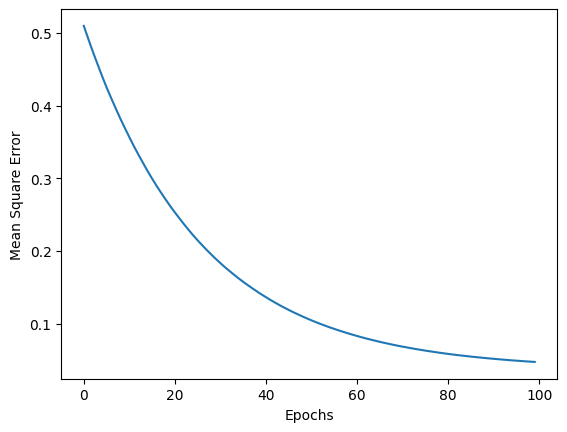

In [98]:
plt.plot(range(len(loss)), loss)
plt.ylabel('Mean Square Error')
plt.xlabel('Epochs')
plt.show()

In [100]:
with torch.no_grad():
    train_res=model.forward(X_train)
    test_results=model.forward(X_test)
train_class=[1 if i>=0.5 else 0 for i in train_res]
correct_train= sum(p == t for p, t in zip(train_class, y_train))
test_class=[1 if i>=0.5 else 0 for i in test_results]
correct= sum(p == t for p, t in zip(test_class, y_test))
print("Train Accuracy: ", correct_train/len(y_train) )
print("Correct : ",correct)
print("Wrong: ",len(y_test)-correct)
print("Accuracy: ", correct/len(y_test) )


Train Accuracy:  tensor(1.)
Correct :  tensor(29)
Wrong:  tensor(1)
Accuracy:  tensor(0.9667)
